In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
from IPython.display import Image, clear_output  # to display images

clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 1.7.0+cu101 _CudaDeviceProperties(name='Tesla V100-SXM2-16GB', major=7, minor=0, total_memory=16130MB, multi_processor_count=80)


In [ ]:
!cp /content/drive/MyDrive/btl_dl/fer2013.tar.gz ./

In [ ]:
!tar -xvf *.tar.gz


fer2013/fer2013.csv
fer2013/README
fer2013/fer2013.bib
fer2013/


In [ ]:
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
%matplotlib inline
import os
import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

Instructions for updating:
Simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


In [ ]:
os.mkdir("./model")

In [ ]:
!rm model/*

In [ ]:
!pip install keras-facenet


     |████████████████████████████████| 2.3MB 4.1MB/s 
  Created wheel for keras-facenet: filename=keras_facenet-0.3.2-cp36-none-any.whl size=10387 sha256=1be1f92fc6afcc68c5bd1e39b833ec6ba4e2303301dc8ab5f523cfa5afbd72f5
  Stored in directory: /root/.cache/pip/wheels/f6/53/9a/36c4b52fd22faf4f710d5047d874655b85a1b2cf77accfb9bd
Successfully built keras-facenet


In [ ]:
from functools import partial

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import add
from tensorflow.keras import backend as K

In [62]:

# Do some code, e.g. train and save model

K.clear_session()

In [63]:
# from keras_facenet import FaceNet
# embedder = FaceNet()

In [66]:
# import keras_facenet
# os.path.dirname(keras_facenet.__file__)

In [67]:
model = None

In [68]:
from tensorflow.keras.applications import EfficientNetB2
eff = EfficientNetB2(include_top = False, input_shape=(96, 96, 3), pooling='avg')

In [70]:
from tensorflow.keras.layers import Input
from tensorflow.keras import regularizers

inputs = Input(shape=(96, 96, 3))
out = eff(inputs)
X = Flatten()(out)
X = Dropout(0.2)(X)
# X = Dense(32,  kernel_initializer = glorot_uniform(seed=0),kernel_regularizer=regularizers.l2(1e-4))(X)
# X = BatchNormalization()(X)
# X = Activation('relu')(X)
# X = Dropout(0.2)(X)
out = Dense(7, activation='softmax', name='fc7', kernel_initializer = glorot_uniform(seed=0))(X)
model = Model(inputs, out)

In [71]:
import cv2
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf
dataset_path = 'fer2013/fer2013.csv'
image_size=(48,48)
batch_size = 32

In [72]:
image_size=(96,96)
def load_fer2013():
    # faces_train = []
    # faces_test = []
    # faces_valid = []
    data = pd.read_csv(dataset_path)
    data = (data[data['pixels'].notnull()])
    print(data['Usage'])
    data_train = data[data['Usage'] == 'Training']
    data_test = data[data['Usage'] == 'PrivateTest']
    data_valid = data[data['Usage'] == 'PublicTest']
    pixels = data_train['pixels'].tolist()
    width, height = 48, 48
    faces = []
    for pixel_sequence in pixels:
        face = [int(pixel) for pixel in pixel_sequence.split(' ')]
        face = np.asarray(face).reshape(width, height)
        face = cv2.resize(face.astype('uint8'),image_size)
        faces.append(face.astype('float32'))
    faces = np.asarray(faces)
    faces = np.expand_dims(faces, -1)
    faces_train = faces
    emotions_train = (data_train['emotion'])#.values
    pixels = data_test['pixels'].tolist()
    faces = []
    for pixel_sequence in pixels:
        face = [int(pixel) for pixel in pixel_sequence.split(' ')]
        face = np.asarray(face).reshape(width, height)
        face = cv2.resize(face.astype('uint8'),image_size)
        faces.append(face.astype('float32'))
    faces = np.asarray(faces)
    faces = np.expand_dims(faces, -1)
    faces_test = faces
    emotions_test = (data_test['emotion'])#.values
    pixels = data_valid['pixels'].tolist()
    faces = []
    for pixel_sequence in pixels:
        face = [int(pixel) for pixel in pixel_sequence.split(' ')]
        face = np.asarray(face).reshape(width, height)
        face = cv2.resize(face.astype('uint8'),image_size)
        faces.append(face.astype('float32'))
    faces = np.asarray(faces)
    faces = np.expand_dims(faces, -1)
    emotions = (data_valid['emotion'])#.values
    return faces_train, emotions_train, faces_test, emotions_test, faces, emotions
 
data = load_fer2013()

0           Training
1           Training
2           Training
3           Training
4           Training
            ...     
35882    PrivateTest
35883    PrivateTest
35884    PrivateTest
35885    PrivateTest
35886    PrivateTest
Name: Usage, Length: 35887, dtype: object


In [73]:
# # data = [faces_train, emotions_train, faces_test, emotions_test, faces_val, emotions_val]
# import pickle
# with open('/content/drive/MyDrive/btl_dl/data.pickle', 'wb') as handle:
#     pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [74]:
faces_train, emotions_train, faces_test, emotions_test, faces_val, emotions_val = data

In [75]:
def smooth_labels(y, smooth_factor):
    '''Convert a matrix of one-hot row-vector labels into smoothed versions.
    https://www.dlology.com/blog/bag-of-tricks-for-image-classification-with-convolutional-neural-networks-in-keras/?fbclid=IwAR2RXBIUkuSdc21cQd3n8AG9CmGtC7MbVgEj3SFm-cfIDyHcexp7YjIhJKs

    # Arguments
        y: matrix of one-hot row-vector labels to be smoothed
        smooth_factor: label smoothing factor (between 0 and 1)

    # Returns
        A matrix of smoothed labels.
    '''
    assert len(y.shape) == 2
    if 0 <= smooth_factor <= 1:
        # label smoothing ref: https://www.robots.ox.ac.uk/~vgg/rg/papers/reinception.pdf
        y *= 1 - smooth_factor
        y += smooth_factor / y.shape[1]
    else:
        raise Exception(
            'Invalid label smoothing factor: ' + str(smooth_factor))
    return y

In [76]:
import tensorflow as tf
from tensorflow.keras.applications.efficientnet import preprocess_input

train_datagen = ImageDataGenerator(
    # rescale=1./255,
    brightness_range = [0.8,1.2],
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=20,
    shear_range=0.1,
    zoom_range=0.1,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator()
def train_gen(train_datagen) :
  while True :
    x, y = next(train_datagen)
    # y = smooth_labels(y, 0.1)
    # x = (x - 127.5) / 127.5
    x = np.concatenate((x,x,x),axis = 3)
    x = preprocess_input(x)
    y = tf.keras.utils.to_categorical(y, num_classes=7)
    y = smooth_labels(y, 0.1)
    yield x, y
def val_gen(val_datagen) :
  while True :
    x, y = next(val_datagen)
    # y = smooth_labels(y, 0.1)
    # x = (x - 127.5) / 127.5
    x = np.concatenate((x,x,x),axis = 3)
    x = preprocess_input(x)
    y = tf.keras.utils.to_categorical(y, num_classes=7)
    yield x, y

In [77]:
batch_size = 64
num_epochs = 150
input_shape = (48, 48, 1)
verbose = 1
num_classes = 7
patience = 20
base_path = './model/'
l2_regularization=0.01

# callbacks
log_file_path = base_path + '_emotion_training.log'
csv_logger = CSVLogger(log_file_path, append=False)
early_stop = EarlyStopping('val_loss', patience=patience)
reduce_lr = ReduceLROnPlateau('val_loss', factor=0.5, patience=int(patience/2), verbose=1)
trained_models_path = base_path + '_mini_XCEPTION'
model_names = trained_models_path + '.{epoch:02d}-{val_accuracy:.2f}.hdf5'
model_checkpoint = ModelCheckpoint(model_names, 'val_accuracy', verbose=1,save_best_only=True)
callbacks = [model_checkpoint, csv_logger, early_stop, reduce_lr]


In [78]:
# !pip install tfa-nightly

In [79]:
# !pip install tensorflow-addons

In [80]:
# from keras.optimizers import Adam, SGD
# model = Net50(input_shape = (48, 48, 1), classes = 7)
# optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7)
import tensorflow_addons as tfa
def focal_loss(gamma=2., alpha=.25):
  def focal_loss_fixed(y_true, y_pred):
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

    # Calculate Cross Entropy
    cross_entropy = -y_true * K.log(y_pred)

    # Calculate Focal Loss
    loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy

    # Compute mean loss in mini_batch
    return K.mean(K.sum(loss, axis=-1))
  return focal_loss_fixed
# optimizer = tfa.optimizers.AdamW(learning_rate=0.001, weight_decay=1e-7)
loss = 'categorical_crossentropy'
# loss = focal_loss(gamma=1.2, alpha=.25)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer= optimizer, loss=loss , metrics=['accuracy'])

In [81]:
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
efficientnetb2 (Functional)  (None, 1408)              7768569   
_________________________________________________________________
flatten_1 (Flatten)          (None, 1408)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1408)              0         
_________________________________________________________________
fc7 (Dense)                  (None, 7)                 9863      
Total params: 7,778,432
Trainable params: 7,710,857
Non-trainable params: 67,575
_________________________________________________________________


In [82]:
from sklearn.utils import class_weight
class_weights = dict(zip(np.unique(emotions_train), class_weight.compute_class_weight('balanced',
                                                 np.unique(emotions_train),
                                                 emotions_train))) 
class_weights

{0: 1.0266046844269623,
 1: 9.406618610747051,
 2: 1.0010460615781582,
 3: 0.5684387684387684,
 4: 0.8491274770777877,
 5: 1.293372978330405,
 6: 0.8260394187886635}

In [84]:
history = model.fit(train_gen(train_datagen.flow(faces_train, emotions_train, batch_size=batch_size)),
                        steps_per_epoch=len(emotions_train) / batch_size,
                        epochs=num_epochs, verbose=1, callbacks=callbacks,
                        validation_data= val_gen(validation_datagen.flow(faces_val, emotions_val, batch_size=batch_size)),
                        validation_steps = len(emotions_val) // batch_size,
                    # class_weight = class_weights
)

Epoch 1/150
449/448 [==============================] - ETA: 0s - loss: 0.6159 - accuracy: 0.9240
Epoch 00001: val_accuracy improved from 0.70061 to 0.70312, saving model to ./model/_mini_XCEPTION.01-0.70.hdf5
449/448 [==============================] - 55s 123ms/step - loss: 0.6159 - accuracy: 0.9240 - val_loss: 1.0100 - val_accuracy: 0.7031
Epoch 2/150
449/448 [==============================] - ETA: 0s - loss: 0.6007 - accuracy: 0.9310
Epoch 00002: val_accuracy did not improve from 0.70312
449/448 [==============================] - 55s 122ms/step - loss: 0.6007 - accuracy: 0.9310 - val_loss: 1.0202 - val_accuracy: 0.6978
Epoch 3/150
449/448 [==============================] - ETA: 0s - loss: 0.5899 - accuracy: 0.9372
Epoch 00003: val_accuracy improved from 0.70312 to 0.70424, saving model to ./model/_mini_XCEPTION.03-0.70.hdf5
449/448 [==============================] - 56s 124ms/step - loss: 0.5899 - accuracy: 0.9372 - val_loss: 1.0029 - val_accuracy: 0.7042
Epoch 4/150
449/448 [=======

KeyboardInterrupt: ignored

In [97]:
model_path = "/content/model/_mini_XCEPTION.06-0.71.hdf5"
model.load_weights(model_path)

In [98]:
model.evaluate_generator(val_gen(validation_datagen.flow(faces_test, emotions_test, batch_size=batch_size)),len(emotions_test)//batch_size)

[1.0227112770080566, 0.7056361436843872]

In [101]:
import cv2
def inference(img_path) :
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
  img = cv2.resize(img, (96,96))
  print(img.shape)
  x = img
  x = np.stack((x,x,x)).transpose(1,2,0)
  x = preprocess_input(x)
  # x = np.concatenate((x,x,x),axis = 2)
  # print(x.shape)
  import time
  t1 = time.time()
  res = model.predict(np.array([x]))
  print(time.time()-t1)
  return res
inference("/content/1_nXqJ4lMiBRp4Ilm3bpRxuA.png")

(96, 96)
0.04983997344970703


array([[0.4667823 , 0.03242487, 0.03954821, 0.30987105, 0.10574244,
        0.0093208 , 0.03631027]], dtype=float32)

In [87]:
while True:pass


KeyboardInterrupt: ignored

**Plot performance metrics.**

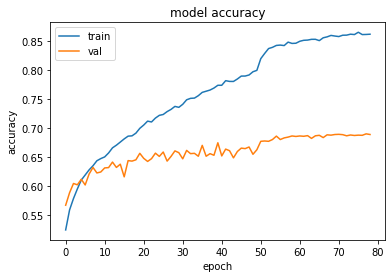

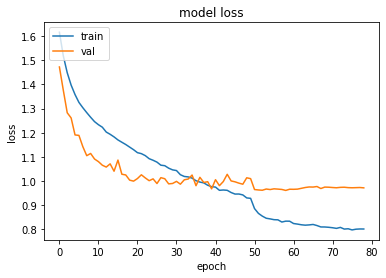

In [ ]:
import keras
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
testloss = model.evaluate(xtest, ytest) 
print("Test Loss " + str(testloss[0]))
print("Test Acc: " + str(testloss[1]))
trainloss = model.evaluate(xtrain, ytrain) 
print("Train Loss " + str(trainloss[0]))
print("Train Acc: " + str(trainloss[1]))

**Visualizing model architecture.**

In [ ]:
plot_model(model, to_file='model.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))